In [167]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
import chromadb
from chromadb.utils import embedding_functions
from tqdm import tqdm
import pandas as pds
from IPython.display import clear_output
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from SonarEmbeddingFunction import SonarEmbeddingFunction
import feedparser
import requests
import re
import torch

import matplotlib.pyplot as plt 
import plotly.express as px 

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import importlib

tensor([1.], device='mps:0')


In [9]:
from chromadb import Documents, EmbeddingFunction, Embeddings
from sonar.inference_pipelines.text import TextToEmbeddingModelPipeline
from newspaper import Article


In [10]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to /Users/ammar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ammar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ammar/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ammar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/ammar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [11]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [12]:
tf.config.list_physical_devices('GPU')

[]

In [14]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


news_sites = [
    "https://www.bbc.com/news",
    "https://www.nytimes.com",
    "https://www.theguardian.com",
    "https://www.cnn.com",
    "https://www.aljazeera.com",
    "https://www.reuters.com",
    "https://www.apnews.com",
    "https://www.washingtonpost.com",
    "https://www.nbcnews.com",
    "https://www.bloomberg.com",
    "https://www.wsj.com",
    "https://www.foxnews.com",
    "https://www.theatlantic.com",
    "https://www.vox.com",
    "https://www.npr.org"
]




def search_feeds(url):
    api_url = f"https://feedsearch.dev/api/v1/search?url={url}"
    try:
        response = requests.get(api_url)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error {response.status_code} for {url}")
            return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


rss_feeds = []

for site in news_sites:
    feeds = search_feeds(site)
    if feeds:
        print(f"Feeds for {site}:")
        for feed in feeds:
            # Only add to the list if it's not a podcast
            if not feed.get('is_podcast', False):
                rss_feeds.append(feed.get('url', 'N/A'))
                print(f" - Title: {feed.get('title', 'N/A')}, URL: {feed.get('url', 'N/A')}")
    print("\n")

In [15]:
rss_feeds = [
    "https://feeds.bbci.co.uk/news/world/rss.xml",
    "http://rss.cnn.com/rss/edition.rss",
    "https://rss.nytimes.com/services/xml/rss/nyt/World.xml",
    "http://feeds.reuters.com/reuters/topNews",
    "https://www.aljazeera.com/xml/rss/all.xml"
]

In [16]:
articles = []

has_summary = 0

for rss_url in tqdm(rss_feeds, desc="RSS Feeds"):
    feed = feedparser.parse(rss_url)
    for entry in feed.entries:
        if "summary" in entry:
            has_summary += 1
        articles.append({
            "title": entry.title,
            "link": entry.link,
        })


RSS Feeds: 100%|██████████| 5/5 [00:00<00:00,  7.57it/s]


In [17]:
articles[0]

{'title': 'IDF soldiers should refuse orders that may be war crimes, Israeli ex-security adviser tells BBC',
 'link': 'https://www.bbc.com/news/articles/cx24ngy9g70o'}

In [18]:
def extract_article_text(url):
    article = Article(url)
    try:
        article.download()
        article.parse()
        return article.text
    except Exception as e:
        print(f"An error occurred while processing {url}: {e}")
        return None

text = extract_article_text(articles[0]["link"])
text

'IDF soldiers should refuse orders that may be war crimes, Israeli ex-security adviser tells BBC\n\nIDF could be committing war crimes in northern Gaza, says Eran Etzion\n\nAs someone who served four Israeli prime ministers and was deputy head of the country’s National Security Council, Eran Etzion’s judgement was trusted at the highest levels of the state. A longstanding critic of Prime Minister Benjamin Netanyahu, he is also someone whose years of public service earned him widespread respect. But now Mr Etzion, a former soldier himself, is warning that Israel’s military - the Israel Defense Forces (IDF) - might be committing war crimes in northern Gaza. And he is suggesting that officers and troops should reject illegal orders. “They should refuse. If a soldier or an officer is expected to commit something that might be suspected as a war crime, they must refuse. That\'s what I would do if I were a soldier. That\'s what I think any Israeli soldier should do,” he tells me. We are sitt

In [19]:
print(len(articles))

160


In [96]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Load stop words from nltk
stop_words = set(stopwords.words('english'))

In [101]:
def clean_text(text):
    
    text = re.sub(r'https?://\S+|www\.\S+', '', str(text)) 

    text = re.sub(r'\n+', ' ', text)
    
    cleaned_text = re.sub(r'[^A-Za-z0-9\s]+', '', text)

    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    cleaned_lemmatized_text = cleaned_text.lower() 

    cleaned_lemmatized_text = re.sub('[^a-z]', ' ', cleaned_lemmatized_text) 
    
    cleaned_lemmatized_text = cleaned_lemmatized_text.split() 

    cleaned_lemmatized_text = [lemmatizer.lemmatize(word) for word in cleaned_lemmatized_text if word not in set( 
		stopwords.words('english'))] 

    cleaned_lemmatized_text = ' '.join(cleaned_lemmatized_text)

    return cleaned_text, cleaned_lemmatized_text


In [102]:
valid_articles = []
for article in tqdm(articles):
    article_text = extract_article_text(article["link"])
    if article_text:
        article_text, cleaned_lemmatized_text = clean_text(article_text)
        if len(article_text) > 0 and isinstance(article_text, str):
            article["text"] = article_text
            article["lemmatized_text"] = cleaned_lemmatized_text
            valid_articles.append(article)  
            
articles = valid_articles

100%|██████████| 158/158 [00:52<00:00,  3.03it/s]


In [104]:
articles[0]

{'title': 'IDF soldiers should refuse orders that may be war crimes, Israeli ex-security adviser tells BBC',
 'link': 'https://www.bbc.com/news/articles/cx24ngy9g70o',
 'text': 'IDF soldiers should refuse orders that may be war crimes Israeli exsecurity adviser tells BBC IDF could be committing war crimes in northern Gaza says Eran Etzion As someone who served four Israeli prime ministers and was deputy head of the countrys National Security Council Eran Etzions judgement was trusted at the highest levels of the state A longstanding critic of Prime Minister Benjamin Netanyahu he is also someone whose years of public service earned him widespread respect But now Mr Etzion a former soldier himself is warning that Israels military the Israel Defense Forces IDF might be committing war crimes in northern Gaza And he is suggesting that officers and troops should reject illegal orders They should refuse If a soldier or an officer is expected to commit something that might be suspected as a wa

In [105]:
df = pd.DataFrame(articles)


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            158 non-null    object
 1   link             158 non-null    object
 2   text             158 non-null    object
 3   lemmatized_text  158 non-null    object
dtypes: object(4)
memory usage: 5.1+ KB


In [107]:
df.head()

,title,link,text,lemmatized_text
0,IDF soldiers should refuse orders that may be ...,https://www.bbc.com/news/articles/cx24ngy9g70o,IDF soldiers should refuse orders that may be ...,idf soldier refuse order may war crime israeli...
1,At least five dead in attack at Turkish aviati...,https://www.bbc.com/news/articles/cwyg565e8wpo,At least five dead in attack at Turkish aviati...,least five dead attack turkish aviation compan...
2,Gisèle Pelicot takes stand in French mass rape...,https://www.bbc.com/news/articles/ckgr2yym0nko,Gisle Pelicot takes stand in French mass rape ...,gisle pelicot take stand french mass rape tria...
3,North Korea troops in Ukraine would escalate c...,https://www.bbc.com/news/articles/c62938gl6q1o,North Korea troops in Ukraine would escalate c...,north korea troop ukraine would escalate confl...
4,Georgia's ruling party holds mass rally ahead ...,https://www.bbc.com/news/articles/c3wpw016434o,Georgias ruling party holds mass rally ahead o...,georgia ruling party hold mass rally ahead cru...


In [85]:
embedding_func = SonarEmbeddingFunction()

In [48]:
embedding = embedding_func([df["text"][100]])

In [49]:
embedding = np.array(embedding)

In [50]:
embedding =torch.from_numpy(embedding.astype(np.float32)).to(device)

In [51]:
device

device(type='mps')

In [37]:
from sonar.inference_pipelines.text import EmbeddingToTextModelPipeline
vec2text_model = EmbeddingToTextModelPipeline(decoder="text_sonar_basic_decoder",
                                              tokenizer="text_sonar_basic_encoder",
                                              device=device)

In [55]:
reconstructed = vec2text_model.predict(embedding, target_lang="eng_Latn", max_seq_len=512)
print(reconstructed)


["The Israeli military campaign against Hezbollah has killed a number of senior leaders of the Lebanese militant group Hezbollah On Saturday, Israel announced another assassination of the leader of Hezbollah, Sa'id Hafezni, a suspected and soon-to-be-deceased successor of the leader of Hezbollah who was killed in an airstrike in early October that targeted a meeting of Hezbollah leaders in the south of Beirut."]


In [142]:
start = -1

In [152]:
start += 1
df['text'][start]


'Russians accused of crimes offered choice go to war instead of court Novosibirsk courts administration Andrey Perlov has been told his case will be frozen if he joins the army At about 0645 on 28 March police arrived at Andrey Perlovs house near Novosibirsk in Siberia They accused him of stealing about three million roubles 32000 24000 from a Novosibirsk football club where he was the managing director he and his family deny this Perlov who is 62 is an Olympic gold medallist having won the 50km race walk in 1992 He has been detained for more than six months and his family says he is being pressured to agree to fight in Ukraine Hes been told that in return the embezzlement case against him would be frozen and potentially dropped when the war ends Getty Images Andrey Perlov centre won a gold medal at the Barcelona Olympics Its no secret that prisoners have been recruited to fight in Ukraine but BBC analysis can reveal how the initial focus on convicted criminals has shifted to include p

float

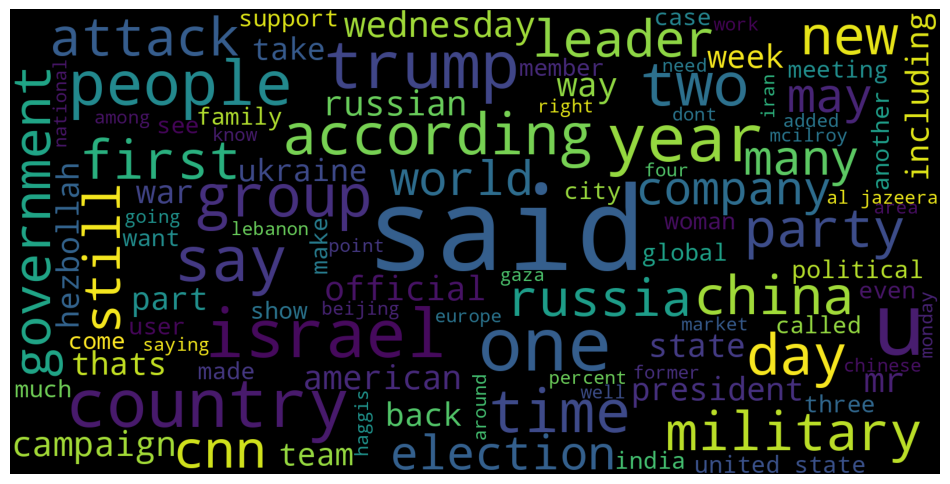

In [161]:
def word_cloud(wd_list): 
	stopwords = set(STOPWORDS) 
	all_words = ' '.join([text for text in wd_list]) 
	wordcloud = WordCloud(background_color='black', 
						stopwords=stopwords, 
						width=1600, height=800, max_words=100, max_font_size=200, 
						colormap="viridis").generate(all_words) 
 
	plt.figure(figsize=(12, 10)) 
	plt.axis('off') 
	plt.imshow(wordcloud) 

word_cloud(df['lemmatized_text'])

In [189]:
CHROMA_DATA_PATH = "chroma_data/"
COLLECTION_NAME = "news_articles"

client = chromadb.PersistentClient(path=CHROMA_DATA_PATH)

In [192]:
try: client.delete_collection(COLLECTION_NAME)
except: print("does not exist")

In [193]:
collection = client.create_collection(
    name=COLLECTION_NAME,
    embedding_function=embedding_func
)

In [194]:
collection = client.get_collection(COLLECTION_NAME, embedding_function=embedding_func)

In [195]:
metadata_cols = df.drop(columns=['title']).to_dict(orient='records')

for i in tqdm(range(len(df)), desc="Adding documents"):
    collection.add(
        documents=[df["title"].iloc[i]],
        metadatas=[metadata_cols[i]],          
        ids=[f"id{i}"]                         
    )

Adding documents: 100%|██████████| 158/158 [00:10<00:00, 15.69it/s]


In [196]:
collection.count()

158

In [197]:
collection.peek(10)

{'ids': ['id0', 'id1', 'id2', 'id3', 'id4', 'id5', 'id6', 'id7', 'id8', 'id9'],
 'embeddings': array([[ 0.00958172, -0.00900653,  0.00399394, ...,  0.01164579,
         -0.01475414,  0.00666587],
        [ 0.00401965, -0.0011236 , -0.00256744, ..., -0.00178202,
         -0.00428881, -0.0010653 ],
        [-0.0049763 ,  0.00436382, -0.00484033, ..., -0.00449238,
         -0.00093389, -0.00612212],
        ...,
        [ 0.00412321, -0.00663378, -0.00203981, ...,  0.00085146,
         -0.00182723, -0.00393049],
        [ 0.00290849, -0.00762326, -0.00173332, ..., -0.00306963,
         -0.00326991,  0.00044855],
        [ 0.01031182, -0.00151356,  0.00087995, ...,  0.01131268,
         -0.00955927,  0.00706207]]),
 'documents': ['IDF soldiers should refuse orders that may be war crimes, Israeli ex-security adviser tells BBC',
  'At least five dead in attack at Turkish aviation company',
  'Gisèle Pelicot takes stand in French mass rape trial',
  'North Korea troops in Ukraine would escala

In [199]:
query_results = collection.query(
    query_texts=["Russia"],
    n_results=3
)
query_results


{'ids': [['id101', 'id76', 'id126']],
 'embeddings': None,
 'documents': [['Wednesday Briefing',
   'Why Is Israel Poised to Attack Iran?',
   'Tuesday Briefing']],
 'uris': None,
 'data': None,
 'metadatas': [[{'lemmatized_text': 'early voter head poll yesterday form early voting commenced seven swing state monday million people already cast vote initial indication republican showing poll returning absentee ballot gusto recent year donald trump thoroughly demonized every method voting didnt occur person election day repeatedly discouraged supporter taking advantage expanded access mailin absentee voting saying method would cause chaos confusion state release early voting data broken partisanship limiting snapshot available data expert closely following ballot return see uptick republican key place monday evening percent roughly ballot submitted nevada came republican percent came democrat sowing doubt handful trump ally already questioning year voting effort could help lay groundwork 

In [120]:
len(collection.get(ids='id0', include=['embeddings'])['embeddings'][0])

1024